# TMDB Data Engineering Project: Modular Pipeline (PySpark)

## Project Structure
- **extraction.api**: Handles API requests.
- **transformation.cleaning**: Handles data cleaning (Spark).
- **analysis.analysis**: Contains logic for KPIs and Ranking (Spark).
- **visualization.plots**: Contains plotting functions (Pandas interface).
- **config.settings**: Configuration (API keys).

In [1]:
import sys
import os
import json
# Add project root to path
sys.path.append(os.path.abspath('..'))

from pyspark.sql import SparkSession
import pandas as pd

from config.settings import MOVIE_IDS
from extraction.api import fetch_movie_data
from transformation.cleaning import clean_movie_data
from analysis.analysis import (
    calculate_kpis, rank_movies, get_franchise_performance, 
    get_director_performance, filter_bruce_willis_scifi, 
    filter_uma_tarantino, compare_franchise_vs_standalone
)
from visualization.plots import (
    set_style, plot_revenue_vs_budget, plot_roi_by_genre, 
    plot_popularity_vs_rating, plot_franchise_comparison, plot_yearly_trends, 
    plot_franchise_vs_standalone
)

# Initialize Spark Session (Required for PySpark functions to work)
spark = SparkSession.builder.appName("TMDB_Notebook_Analysis").master("local[*]").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

set_style()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/25 21:42:02 WARN Utils: Your hostname, ChefIT.local, resolves to a loopback address: 127.0.0.1; using 172.20.10.3 instead (on interface en0)
26/01/25 21:42:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/25 21:42:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Step 1: Fetch & Clean Data

In [2]:
print(f"Fetching data for {len(MOVIE_IDS)} movies...")
raw_data_list = fetch_movie_data(MOVIE_IDS)

# Convert raw list of dicts to Spark DataFrame (JSON RDD method for robustness)
json_rdd = spark.sparkContext.parallelize([json.dumps(r) for r in raw_data_list])
raw_df = spark.read.json(json_rdd)

df_spark = clean_movie_data(raw_df)
df_spark = calculate_kpis(df_spark)

# For quick display in notebook, we show the Spark DF
df_spark.select('title', 'release_date', 'revenue_musd', 'budget_musd', 'profit_musd', 'roi').show(5)

Starting fetch for 19 movies...


Fetching data for 19 movies...


Movie ID 0 not found (404). Skipping.
Successfully fetched movie ID 299534
Successfully fetched movie ID 19995
Successfully fetched movie ID 140607
Successfully fetched movie ID 299536
Successfully fetched movie ID 597
Successfully fetched movie ID 135397
Successfully fetched movie ID 420818
Successfully fetched movie ID 24428
Successfully fetched movie ID 168259
Successfully fetched movie ID 99861
Successfully fetched movie ID 284054
Successfully fetched movie ID 12445
Successfully fetched movie ID 181808
Successfully fetched movie ID 330457
Successfully fetched movie ID 351286
Successfully fetched movie ID 109445
Successfully fetched movie ID 321612
Successfully fetched movie ID 260513
Batch fetch complete. Retrieved 18 movies.
26/01/25 21:42:20 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.1

Data cleaning complete.
+--------------------+------------+------------+-----------+-----------+-----------------+
|               title|release_date|revenue_musd|budget_musd|profit_musd|              roi|
+--------------------+------------+------------+-----------+-----------+-----------------+
|             Titanic|  1997-12-18| 2264.162353|      200.0|2064.162353|     11.320811765|
|Harry Potter and ...|  2011-07-12| 1341.511219|      125.0|1216.511219|     10.732089752|
|              Avatar|  2009-12-16| 2923.706026|      237.0|2686.706026|12.33631234599156|
|        The Avengers|  2012-04-25| 1518.815515|      220.0|1298.815515|6.903706886363636|
|Avengers: Age of ...|  2015-04-22| 1405.403694|      235.0|1170.403694| 5.98044125106383|
+--------------------+------------+------------+-----------+-----------+-----------------+
only showing top 5 rows


# Step 2: KPI Analysis

In Spark, we operate on the distributed DataFrame. We use `.show()` to view results or `.toPandas()` if we need pretty printing.

In [3]:
print("TOP 5 Highest Revenue")
rank_movies(df_spark, 'revenue_musd', top_n=5, ascending=False).select('title', 'revenue_musd').show(truncate=False)

print("\nTOP 5 Highest Budget")
rank_movies(df_spark, 'budget_musd', top_n=5, ascending=False).select('title', 'budget_musd').show(truncate=False)

print("\nTOP 5 Highest Profit")
rank_movies(df_spark, 'profit_musd', top_n=5, ascending=False).select('title', 'profit_musd').show(truncate=False)

print("\nTOP 5 ROI (Budget >= 10M)")
rank_movies(df_spark, 'roi', top_n=5, ascending=False, min_budget=10).select('title', 'roi').show(truncate=False)

print("\nHighest Rated Movies (>= 10 votes)")
rank_movies(df_spark, 'vote_average', top_n=5, ascending=False, min_votes=10).select('title', 'vote_average', 'vote_count').show(truncate=False)

print("\nMost Popular Movies")
rank_movies(df_spark, 'popularity', top_n=5, ascending=False).select('title', 'popularity').show(truncate=False)

TOP 5 Highest Revenue
+----------------------------+------------+
|title                       |revenue_musd|
+----------------------------+------------+
|Avatar                      |2923.706026 |
|Avengers: Endgame           |2799.4391   |
|Titanic                     |2264.162353 |
|Star Wars: The Force Awakens|2068.223624 |
|Avengers: Infinity War      |2052.415039 |
+----------------------------+------------+


TOP 5 Highest Budget
+----------------------------+-----------+
|title                       |budget_musd|
+----------------------------+-----------+
|Avengers: Endgame           |356.0      |
|Star Wars: The Last Jedi    |300.0      |
|Avengers: Infinity War      |300.0      |
|The Lion King               |260.0      |
|Star Wars: The Force Awakens|245.0      |
+----------------------------+-----------+


TOP 5 Highest Profit
+----------------------------+------------------+
|title                       |profit_musd       |
+----------------------------+------------------+

## 2.2 Advanced Filtering

In [4]:
print("Search 1: Sci-Fi Action starring Bruce Willis")
res1 = filter_bruce_willis_scifi(df_spark)
if res1: res1.show(truncate=False)

print("\nSearch 2: Uma Thurman directed by Quentin Tarantino")
res2 = filter_uma_tarantino(df_spark)
if res2: res2.show(truncate=False)

Search 1: Sci-Fi Action starring Bruce Willis
+-----+------------+------+------------+
|title|vote_average|genres|release_date|
+-----+------------+------+------------+
+-----+------------+------+------------+


Search 2: Uma Thurman directed by Quentin Tarantino
+-----+--------+-------+------------+
|title|director|runtime|release_date|
+-----+--------+-------+------------+
+-----+--------+-------+------------+



## 2.3 Franchise vs Standalone Analysis

Franchise vs Standalone Performance Comparison


,collection_status,revenue_musd,budget_musd,popularity,vote_average,median_roi
0,Franchise,1682.668411,218.0,20.389619,7.388062,7.708641
1,Standalone,1765.139159,180.0,25.177150,7.435000,7.913225


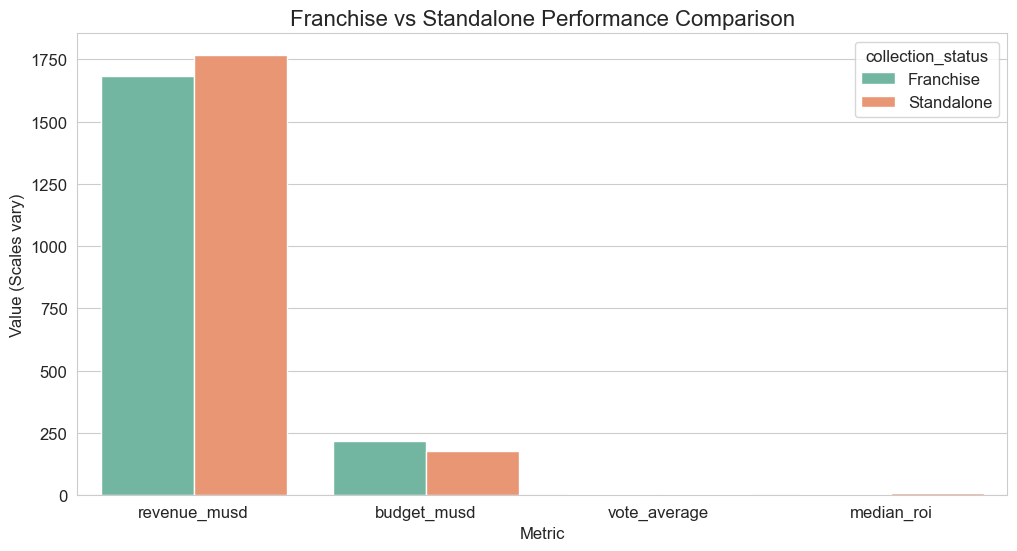

In [5]:
print("Franchise vs Standalone Performance Comparison")
comp = compare_franchise_vs_standalone(df_spark)
# Convert to Pandas for cleaner display if it's small
if comp: 
    comp_pd = comp.toPandas()
    display(comp_pd)
    plot_franchise_vs_standalone(comp_pd)


## 2.4 Most Successful Franchises & Directors

In [6]:
print("Top Franchises")
franchises_spark = get_franchise_performance(df_spark)
franchises_spark.show(5, truncate=False)

print("\nTop Directors")
directors_spark = get_director_performance(df_spark)
directors_spark.show(5, truncate=False)

Top Franchises
+------------------------+-----------+------------+----------+------------------+------------------+----------+------------------+
|belongs_to_collection   |movie_count|total_budget|avg_budget|total_revenue     |avg_revenue       |avg_rating|avg_popularity    |
+------------------------+-----------+------------+----------+------------------+------------------+----------+------------------+
|The Avengers Collection |4          |1111.0      |277.75    |7776.073348       |1944.018337       |7.9155    |34.775625000000005|
|Star Wars Collection    |2          |545.0       |272.5     |3400.9224540000005|1700.4612270000002|7.0065    |9.915099999999999 |
|Jurassic Park Collection|2          |320.0       |160.0     |2982.0064810000003|1491.0032405000002|6.6175    |11.837299999999999|
|Avatar Collection       |1          |237.0       |237.0     |2923.706026       |2923.706026       |7.6       |48.0098           |
|Frozen Collection       |2          |300.0       |150.0     |2727.9

# Step 3: Visualization
Note: Spark DataFrames must be collected to the driver (converted to Pandas) for plotting with Seaborn/Matplotlib.

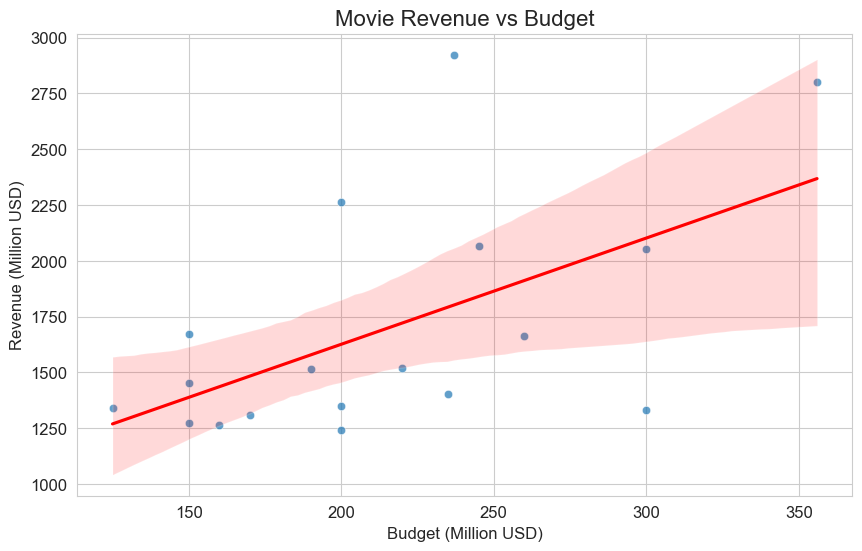

In [7]:
# Collect data for plotting
df_pd = df_spark.toPandas()

plot_revenue_vs_budget(df_pd)

/Users/tijanimubarak/Desktop/GITHUB_CLONES/TMDB_SPARK/visualization/plots.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=roi_by_genre.values, y=roi_by_genre.index, palette='viridis')


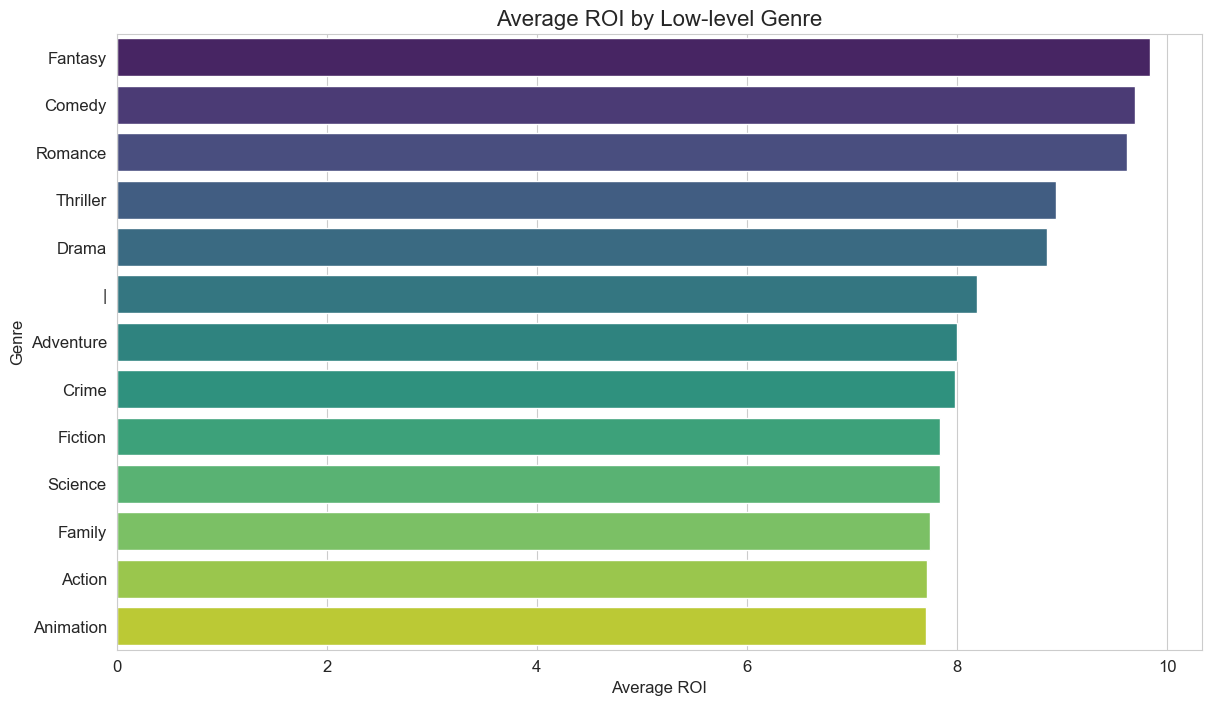

In [8]:
plot_roi_by_genre(df_pd)

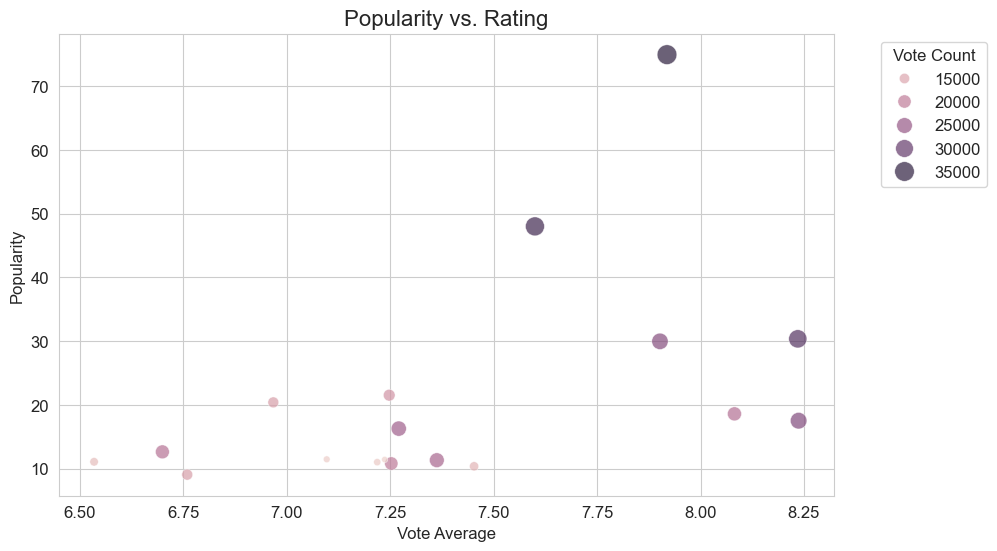

In [9]:
plot_popularity_vs_rating(df_pd)

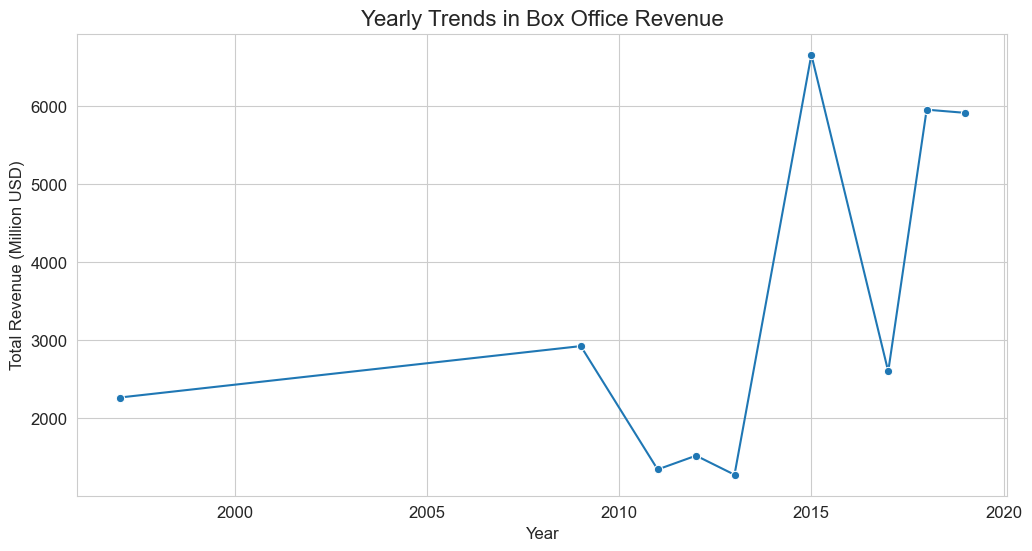

In [10]:
plot_yearly_trends(df_pd)

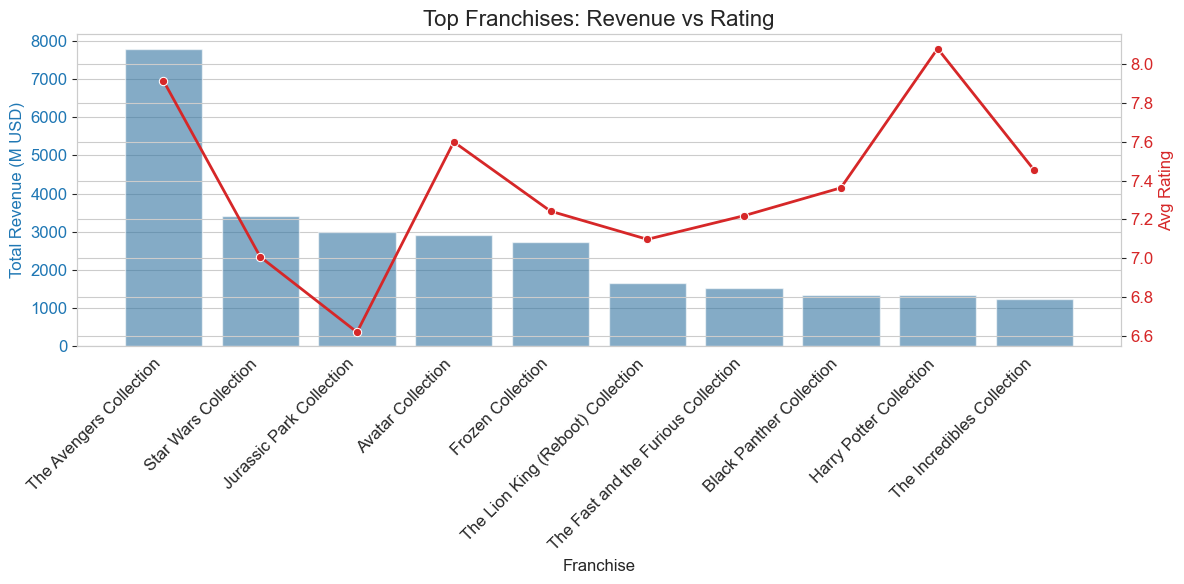

In [11]:
franchises_pd = franchises_spark.toPandas()
franchises_pd.set_index('belongs_to_collection', inplace=True)
plot_franchise_comparison(franchises_pd)